## Codes

### import

In [1]:
import pandas as pd
import numpy as np
import random
import pickle

import collections
from collections import defaultdict, Counter

import scipy.sparse as sp
from sklearn.metrics import ndcg_score, dcg_score


from time import time
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

# from tensorflow.keras import backend as K
from tensorflow import keras

# from google.colab import drive
# drive.mount('/content/drive')
import argparse
tf.config.run_functions_eagerly(True)

In [2]:
# %cd '/content/drive/My Drive/Colab Notebooks'
# %ls

### utils

In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run GMF.")
    parser.add_argument('--path', nargs='?', default='data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='ml-1m',
                        help='Choose a dataset.')
    parser.add_argument('--nnModel', nargs='?', default='NextItNet_DistributedWeights', #[NextItNet_DistributedWeights, Bert4Rec]
                        help='Choose a recommender system model.')
    parser.add_argument('--mode', type=int, default=1,
                        help='Enter which uncertainty model is training')
    parser.add_argument('--seqlen', type=int, default=100,
                        help='Enter Sequence Length.')
    parser.add_argument('--T', type=int, default=10,
                        help='Enter T.')
    parser.add_argument('--tarlen', type=int, default=1,
                        help='Enter Target Length.')
    parser.add_argument('--setseed', type=int, default=2022,
                        help='Set a seed for random generator.')
    parser.add_argument('--max_epochs', type=int, default=10,
                        help='Number of epochs.')
    parser.add_argument('--embed_dims', type=int, default=32,
                        help='Embedding Dimension')
    parser.add_argument('--residual_channels', type=int, default=32,
                        help='CNN Residual Channels')
    parser.add_argument('--kernel_size', type=int, default=3,
                        help='CNN Kernel Size')
    parser.add_argument('--dilations', type=int, default=[1, 2, 4],
                        help='CNN Dilations')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--num_factors', type=int, default=8,
                        help='Embedding size.')
    parser.add_argument('--regs', nargs='?', default='[0,0]',
                        help="Regularization for user and item embeddings.")
    parser.add_argument('--num_neg', type=int, default=4,
                        help='Number of negative instances to pair with a positive instance.')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_known_args()

args, __ = parse_args()


In [4]:
# utils.py

def set_seed(seed, cuda=False):

    np.random.seed(seed)
    random.seed(seed)

set_seed(2023)

### Interactions

In [5]:
# args.path = '/content/drive/My Drive/Colab Notebooks/UncertaintyProject/data/'
args.path = ''
args.dataset = 'ml-100k'


### Instance Spliter

In [6]:
class Instances:
    def __init__(self, name=''):
        self.name=name
        self.sequences = []
        self.ratings = []
        self.users = []
        self.targets = []  # movie ids

    def shuffle(self):
        shuffle_indices = np.arange(len(self.sequences))
        np.random.shuffle(shuffle_indices)

        self.sequences = self.sequences[shuffle_indices]
        self.ratings = self.ratings[shuffle_indices]
        self.users = self.users[shuffle_indices]
        self.targets = self.targets[shuffle_indices]


    def pprint(self):
        print('Data Instances Shape:', self.name, end='\n')
        print('Sequences:', self.sequences.shape, 'Users:', self.users.shape, 'Targets:', self.targets.shape, 'Ratings:', self.ratings.shape)

class Interactions:
    def __init__(self, args):
        self.args = args
        self.sequence_length = args.seqlen
        self.target_length = args.tarlen
        self.data_root = args.path + args.dataset

        self.user_interactions = []
        self.user_ratings = []
        self.train = Instances(name='Train Instances')
        self.test = Instances(name='Test Instances')
        self.num_users = 0
        self.num_items = 0
        self.num_sequences = 0

    def process_dataset(self):
        print('Root', self.data_root)
        self._read_file(self.data_root + '/ml-100k')
        self.user_interactions = np.array(self.user_interactions, dtype=object)
        self.user_ratings = np.array(self.user_ratings, dtype=object)

        self.num_users = self.user_interactions.shape[0]
        self.num_items = int(np.max(np.concatenate(self.user_interactions[:])))

        print('num_users = ', self.num_users)
        print('num_items = ', self.num_items)

    def _read_file(self, file_path):
        with open(file_path, 'r') as fin:
            for line in fin:
                item_ratings = line.strip().split()[1:]
                item_ratings_np = np.array(item_ratings).astype(np.int64).reshape(-1, 2)
                
                ### users must have rated at least 15 items
                # if item_ratings_np.shape[0] >= 15:
                self.user_interactions.append(item_ratings_np[:, 0])
                self.user_ratings.append(item_ratings_np[:, 1])

    def create_instances(self):
        self._create_test_instances()
        self._create_train_instances()

    def _create_test_instances(self):

        ### Creating last item as prediction item
        ### Test targets are compaible with sigmoid output and sparse softmax out
        for user_id, interaction in enumerate(zip(self.user_interactions, self.user_ratings)):
            # interaction[0] --> user sequenes
            # interaction[1] --> user ratings
            sequence_interation = interaction[0]
            sequnece_rating = interaction[1]

            if len(sequence_interation) < 3:
                continue
            ### Users
            self.test.users.append(user_id)

            ### Targets
            self.test.targets.append(sequence_interation[-self.target_length:] - 1)

            ### Sequences
            sequence_interation = sequence_interation[:-self.target_length]  # Most important line
            sequnece_rating = sequnece_rating[:-self.target_length]  # Most important line

            if len(sequence_interation) < self.sequence_length:
                num_paddings = self.sequence_length - len(sequence_interation)
                sequence_interation = np.pad(sequence_interation, (num_paddings, 0), 'constant')
                sequnece_rating = np.pad(sequnece_rating, (num_paddings, 0), 'constant')
            else:
                sequence_interation = sequence_interation[-self.sequence_length:]
                sequnece_rating = sequnece_rating[-self.sequence_length:]

            self.test.sequences.append(sequence_interation)
            self.test.ratings.append(sequnece_rating)

        self.test.targets = np.array(self.test.targets).reshape(-1, self.target_length)
        ### users
        self.test.users = np.array(self.test.users).reshape(-1, 1)
        self.test.sequences = np.array(self.test.sequences)
        self.test.ratings = np.array(self.test.ratings)

        self.test.pprint()

    def _create_train_instances(self):
        max_sequence_length = self.sequence_length + self.target_length

        self.user_sequence_indexes = [list() for i in range(self.num_users)]

        sequence_index = 0
        for user_id, interaction in enumerate(zip(self.user_interactions, self.user_ratings)):
            # interaction[0] --> user sequenes
            # interaction[1] --> user ratings
            sequence_interation = interaction[0]
            sequnece_rating = interaction[1]

            if len(sequence_interation) < 3:
                continue
            sequence_interation = sequence_interation[:-self.target_length]  # Most important line
            sequnece_rating = sequnece_rating[:-self.target_length]  # Most important line

            if len(sequence_interation) < max_sequence_length:
                num_paddings = max_sequence_length - len(sequence_interation)
                sequence_interation = np.pad(sequence_interation, (num_paddings, 0), 'constant')
                sequnece_rating = np.pad(sequnece_rating, (num_paddings, 0), 'constant')

                self._add_sequence(
                    seq=sequence_interation[:self.sequence_length], 
                    usr=user_id, 
                    rating=sequnece_rating[:self.sequence_length], 
                    target=sequence_interation[-self.target_length:], 
                    sequence_index=sequence_index
                )
                sequence_index += 1

            else:
                for ind in range(len(sequence_interation), max_sequence_length - 1, -1):
                    temp_sequence = sequence_interation[ind - max_sequence_length: ind]
                    temp_rating = sequnece_rating[ind - max_sequence_length: ind]
                    self._add_sequence(
                        seq=temp_sequence[:self.sequence_length], 
                        usr=user_id, 
                        rating=temp_rating[:self.sequence_length], 
                        target=temp_sequence[-self.target_length:], 
                        sequence_index=sequence_index
                    )
                    sequence_index += 1

        self.train.sequences = np.array(self.train.sequences)
        self.train.ratings = np.array(self.train.ratings)
        self.train.users = np.array(self.train.users).reshape(-1, 1)
        self.train.targets = np.array(self.train.targets)
        self.train.pprint()

        for user_id in range(self.num_users):
            self.user_sequence_indexes[user_id] = np.array(self.user_sequence_indexes[user_id])
        self.user_sequence_indexes = np.array(self.user_sequence_indexes, dtype=object)

        self.num_sequences = sequence_index

    def _add_sequence(self, seq, usr, rating, target, sequence_index):
        self.train.sequences.append(seq)
        self.train.ratings.append(rating)
        self.train.users.append(usr)
        if target == 0:
            self.train.targets.append(target)
        else:
            self.train.targets.append(target - 1)

        self.user_sequence_indexes[usr].append(sequence_index)
        

In [7]:
class InstanceSpliter:

    def __init__(self, data, k_fold = 5):
        self.data = data
        self.k_fold = k_fold

    def generate_folds(self):
        n_user_fold = self.data.num_users // self.k_fold
        user_ids = np.arange(self.data.num_users)
        np.random.shuffle(user_ids)

        ### Find folds for users
        self.user_fold_indexes = []
        for fold in range(self.k_fold):
            self.user_fold_indexes.append(user_ids[fold*n_user_fold : (fold+1)*n_user_fold])
        self.user_fold_indexes = np.array(self.user_fold_indexes)

    def get_sequence_indexes(self, fold_indexes):
        # print(fold_indexes)
        return np.concatenate(self.data.user_sequence_indexes[fold_indexes])

    def get_sequence(self, sequence_indexes, isTest=False):
        _instances = Instances()
        if isTest:
            _split_instances = self.data.test
        else:
            _split_instances = self.data.train

        print(type(sequence_indexes))
        _instances.users = _split_instances.users[sequence_indexes]
        _instances.sequences = _split_instances.sequences[sequence_indexes]
        _instances.ratings = _split_instances.ratings[sequence_indexes]
        _instances.targets = _split_instances.targets[sequence_indexes]

        return _instances

    def split_data(self, fold_id=0):
        if fold_id >= self.k_fold:
            raise Exception('Fold Id must be less than the k_fold')

        test_user_indexes = self.user_fold_indexes[fold_id]
        train_user_indexes = np.array(list(set(np.arange(self.data.num_users)) - set(self.user_fold_indexes[fold_id])))

        return self.create_split(train_user_indexes, test_user_indexes)
        
    def create_split(self, train_user_indexes, test_user_indexes):    
        train_sequence_indexes = self.get_sequence_indexes(train_user_indexes)
        validation_sequence_indexes = self.get_sequence_indexes(test_user_indexes)

        train_set = self.get_sequence(train_sequence_indexes)
        validation_set = self.get_sequence(validation_sequence_indexes)
        test_set = self.get_sequence(test_user_indexes, isTest=True)

        # if len(set(train_set.users.squeeze()).intersection(set(test_set.users.squeeze())))==0:
        # if len(set(train_user_indexes).intersection(set(test_user_indexes))) == 0:
        #     print('Well Done')
        # else:
        #     print('Error Splitting')
        print(train_set.users.shape, validation_set.users.shape, np.unique(train_set.users.squeeze()).shape, validation_set.users.shape)

        train_set.shuffle()
        validation_set.shuffle()
    
        return train_set, validation_set, test_set


def init(args, k_fold=5):
    set_seed(args.setseed)

    # load dataset
    instances = Interactions(args)
    instances.process_dataset()
    instances.create_instances()

    # get_target_samples(instances, num_negative_samples=1)

    instance_spliter = InstanceSpliter(data=instances, k_fold=k_fold)
    instance_spliter.generate_folds()

    return instances, instance_spliter

In [8]:
args.seqlen = 100
args.embed_dims=64
args.residual_channels=64

data, spliter = init(args)
train, validation, test = spliter.split_data(fold_id=0)

Root ml-100k
num_users =  943
num_items =  1681
Data Instances Shape: Test Instances
Sequences: (943, 100) Users: (943, 1) Targets: (943, 1) Ratings: (943, 100)
Data Instances Shape: Train Instances
Sequences: (38346, 100) Users: (38346, 1) Targets: (38346, 1) Ratings: (38346, 100)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(31922, 1) (6424, 1) (755,) (6424, 1)


### Uncertainty Calculations

In [9]:
def CustomSparseCategoricalCrossentropyLoss(T):
    def Custom_Loss(y_true, y_pred):
        varience = y_pred[:, -1]
        before_softmax = y_pred[:, :-1]

        std = tf.sqrt(varience)
        dist = tfd.Normal(loc=tf.zeros_like(std), scale=std)

        std_samples = tf.transpose(dist.sample(y_pred.shape[1]))
        std_samples = tf.reshape(std_samples, shape=(tf.shape(y_pred)[0], y_pred.shape[1]))
        monte_carlo_results = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred + std_samples, from_logits=True)
        
        variance_loss = tf.reduce_mean(monte_carlo_results, axis=0)

        return tf.math.log(variance_loss)
    return Custom_Loss

def CustomSparseTopKCategoricalAccuracy(y_true, y_pred):

    varience = tf.reshape(y_pred[:,-1], (-1,1))
    y_pred = y_pred[:,:-1]
    y_pred = tf.nn.softmax(y_pred)

    m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)
    m.update_state(y_true, y_pred)
    return m.result()

    # return tf.math.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float64))



In [10]:
def test_model(nnRecModel, train, val, test):
    max_epochs = 10
    verbose = 1
    batch_size = 512
    for iteration in range(max_epochs):
        history = nnRecModel.fit(train.sequences, train.targets,
            verbose=verbose, 
            batch_size=batch_size,
            # validation_data=(val.sequences, val.targets),
            # validation_batch_size=batch_size,
            callbacks=tf.keras.callbacks.TerminateOnNaN(),
        )
        y_pred = nnRecModel.predict(test.sequences, batch_size=batch_size)
        print('Test Accuracy: ', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred))

In [11]:
class nnRecSys:
    def __init__(self, args, data):
        self.T = args.T
        self.data = data
        self.saved_dir = 'results/'
        self.sequence_length = args.seqlen
        self.num_users = data.num_users
        self.num_items = data.num_items  # Consider padding 0 a prediction

    def compile_model(self, inputs, outputs):
        model = tf.keras.Model(
            inputs=inputs,
            outputs=outputs,
        )
        ### model compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, clipvalue=1.0),
            # optimizer=tf.keras.optimizers.Adam(
            #     learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=200, decay_rate=0.80, staircase=True, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=250, alpha=0.0, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-4, decay_steps=400, decay_rate=0.75, name=None)

            # ),
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            loss=CustomSparseCategoricalCrossentropyLoss(self.T),
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )

        return model

args.T = 1


In [12]:
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

model = tfk.Sequential([
  tfkl.Dense(1681, input_dim=100),
  tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.Normal(loc=t[..., 0], scale=tf.exp(t[..., 1])),
    convert_to_tensor_fn=lambda s: s.sample(1681))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1681)              169781    
                                                                 
 distribution_lambda (Distri  ((1681, None),           0         
 butionLambda)                (1681, None))                      
                                                                 
Total params: 169,781
Trainable params: 169,781
Non-trainable params: 0
_________________________________________________________________


#### NextItNet

(None, 1)
Sampled Shape from distribution: (None, 1681)


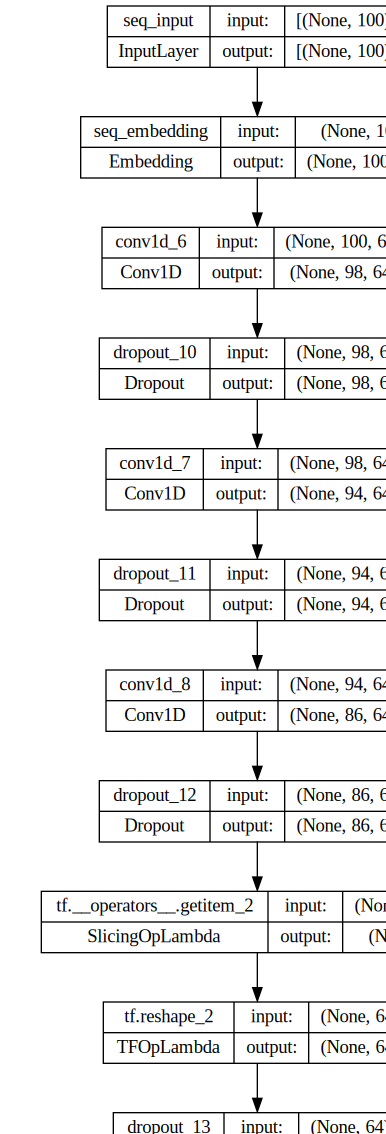

In [16]:
def CustomLoss():
    def Custom_Loss(y_true, y_pred):
        # print(y_pred.shape)
        # print(y_true.shape)
        return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    return Custom_Loss

lmbda = 0.125

class NextItNet_Dropout(nnRecSys):
    def __init__(self, args, data):        
        super(NextItNet_Dropout, self).__init__(args, data)
        self.saved_dir = self.saved_dir + 'NextItNet_Dropout/' + args.dataset + '/'
        self.embed_dim = args.embed_dims                    # 256
        self.residual_channels = args.residual_channels     # 256
        self.dilations = args.dilations                     # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        self.kernel_size = args.kernel_size            # 3

    def get_model(self, drop_prob=0.25, isDropoutTraining=True):
        # embed_dim = 64          # 256
        # embed_size = 64         # 256
        # dilations = [1, 2, 4]   # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        # residual_channels = 32  # 256
        # kernel_size = 3         # 3

        user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
        item_input = tf.keras.layers.Input(shape=(1,), name='item_input')

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')


        user_embed = tf.keras.layers.Embedding(self.num_users, self.embed_dim, embeddings_regularizer=tf.keras.regularizers.L2(0))(user_input) #(N, k)
        item_embed = tf.keras.layers.Embedding(self.num_items, self.embed_dim, embeddings_regularizer=tf.keras.regularizers.L2(0))(item_input) #(M, k)

        


        # (batch_size, sequence_length, embed_dim) --> (None, 100, 64)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items, 
            output_dim = self.embed_dim,
            name='seq_embedding',
            embeddings_initializer='uniform',       #embeding.weight.data.uniform_(-stdv, stdv) # important initializer, stdv = np.sqrt(1. / self.item_size)
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input) #(batch_size, seq_len, embed_dim) = (None, 100, 64)
        # conv_layer = tf.keras.layers.Dropout(drop_prob)(seq_embedding, training=isDropoutTraining)
        conv_layer=seq_embedding

        # conv_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(conv_layer) #(batch_size, seq_len, embed_dim, 1) (None, 100, 64, 1)


        for dilation in self.dilations: #[1, 2, 4]

            conv_layer = tf.keras.layers.Conv1D(
                    self.residual_channels, 
                    kernel_size=self.kernel_size, 
                    dilation_rate=dilation, 
                    padding='valid', 
                    activation='tanh',
                )(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 98, 32), (None, 100, 94, 32), (None, 100, 86, 32)
            conv_layer = tf.keras.layers.Dropout(drop_prob)(conv_layer, training=isDropoutTraining)

        flatten_layer = tf.reshape(conv_layer[:, -1,], (-1, self.residual_channels)) # (batch_size, embed_dim) = (None, 32)
        flatten_layer = tf.keras.layers.Dropout(drop_prob)(flatten_layer, training=isDropoutTraining)
        
        variance_layer = tf.keras.layers.Dense(1, activation='softplus',name='variance')(flatten_layer)
        print(variance_layer.shape)

        # std = tf.sqrt(variance_layer)
        # print(std.shape)
        # dist = tfd.Normal(loc=tf.zeros_like(std), scale=std)
        # # print(dist.shape)
        # std_samples = tf.transpose(dist.sample(self.num_items))
        # std_samples = tf.reshape(std_samples, shape=(512, self.num_items))


        fully_connected_layer = tf.keras.layers.Dense(self.num_items+1)(flatten_layer) # (batch_size, num_items) = (None, 3417)
        fully_connected_layer = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=isDropoutTraining)

        # output_layer = tf.keras.layers.concatenate([fully_connected_layer, variance_layer], name='output_layer')

        output_layer = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Normal(loc=t[..., :self.num_items], scale=tf.nn.softplus(t[..., self.num_items:])),
            convert_to_tensor_fn=tfd.Distribution.sample
            # convert_to_tensor_fn=lambda s: s.sample(100)
        )(fully_connected_layer)
        # output_layer = output_layer[0]
        print('Sampled Shape from distribution:', output_layer.shape)
        # logits_variance = tf.keras.layers.concatenate([fully_connected_layer, variance_layer], name='logits_variance')

        # final_ratings = (1-lmbda) * fully_connected_layer
        #  + lmbda * output_layer
        # print(final_ratings.shape)
        # output_layer = tf.keras.layers.Dense(self.num_items)(output_layer)

        # output_layer = (1-lmbda) * fully_connected_layer[:, :-1] + lmbda * output_layer
        model = tf.keras.Model(
            inputs=seq_input,
            outputs=output_layer
            # outputs=fully_connected_layer[:, :self.num_items],
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, clipvalue=1.0),
            # optimizer=tf.keras.optimizers.Adam(
            #     learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=200, decay_rate=0.80, staircase=True, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=250, alpha=0.0, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-4, decay_steps=400, decay_rate=0.75, name=None)

            # ),
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            loss=CustomLoss(),
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )

        return model

def test_model(nnRecModel, train, val, test):
    max_epochs = 10
    verbose = 1
    batch_size = 512
    # for iteration in range(max_epochs):
    hist = nnRecModel.fit(train.sequences, train.targets,
        verbose=verbose, 
        batch_size=batch_size,
        epochs=max_epochs,
        # validation_data=(val.sequences, val.targets),
        # validation_batch_size=batch_size,
        callbacks=tf.keras.callbacks.TerminateOnNaN(),
    )
        # y_pred = nnRecModel.predict(test.sequences, batch_size=batch_size)
        # print('Test Accuracy: ', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred))
    return hist

# model = GRU(args, data, T=100).get_model(drop_prob=0.25)
model = NextItNet_Dropout(args, data).get_model(drop_prob=0.25)

# model = NextItNet_Dropout(data, T=100).get_model(drop_prob=0.25)
# model.summary()
# hist = test_model(model, train, validation, test)
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
hist = test_model(model, train, validation, test)

Epoch 1/10


c:\Users\Carrt\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


InvalidArgumentError: Exception encountered when calling layer 'seq_embedding' (type Embedding).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[386,20] = 1681 is not in [0, 1681) [Op:ResourceGather]

Call arguments received by layer 'seq_embedding' (type Embedding):
  • inputs=tf.Tensor(shape=(512, 100), dtype=float32)

In [ ]:
train.targets

array([[2566],
       [  49],
       [3301],
       ...,
       [1537],
       [ 320],
       [1914]])

### NextItNet_Vanila

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 100)]             0         
                                                                 
 seq_embedding (Embedding)   (None, 100, 64)           107584    
                                                                 
 conv1d_105 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 dropout_168 (Dropout)       (None, 100, 64)           0         
                                                                 
 conv1d_106 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 dropout_169 (Dropout)       (None, 100, 64)           0         
                                                                 
 conv1d_107 (Conv1D)         (None, 100, 64)           123

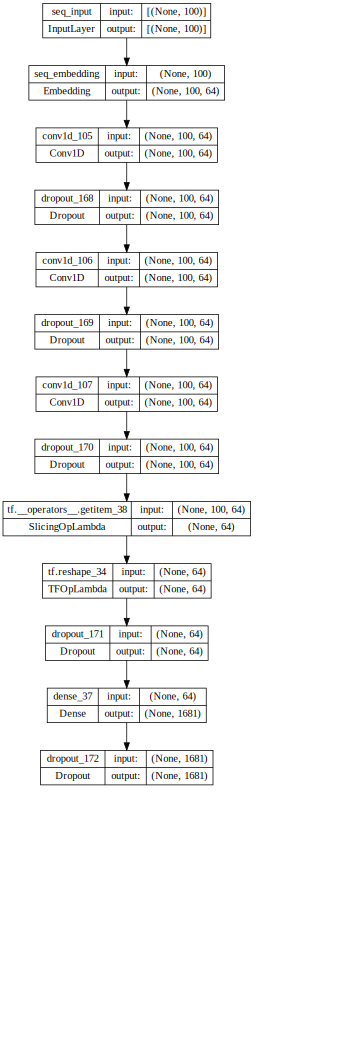

In [ ]:
class NextItNet_Dropout(nnRecSys):
    def __init__(self, args, data):        
        super(NextItNet_Dropout, self).__init__(args, data)
        self.saved_dir = self.saved_dir + 'NextItNet_Dropout/' + args.dataset + '/'
        self.embed_dim = args.embed_dims                    # 256
        self.residual_channels = args.residual_channels     # 256
        self.dilations = args.dilations                     # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        self.kernel_size = args.kernel_size            # 3

    def get_model(self, drop_prob=0.25, isDropoutTraining=True):
        # embed_dim = 64          # 256
        # embed_size = 64         # 256
        # dilations = [1, 2, 4]   # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        # residual_channels = 32  # 256
        # kernel_size = 3         # 3

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')

        # (batch_size, sequence_length, embed_dim) --> (None, 100, 64)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items, 
            output_dim = self.embed_dim,
            name='seq_embedding',
            embeddings_initializer='uniform',       #embeding.weight.data.uniform_(-stdv, stdv) # important initializer, stdv = np.sqrt(1. / self.item_size)
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input) #(batch_size, seq_len, embed_dim) = (None, 100, 64)
        # conv_layer = tf.keras.layers.Dropout(drop_prob)(seq_embedding, training=isDropoutTraining)
        conv_layer=seq_embedding

        # conv_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(conv_layer) #(batch_size, seq_len, embed_dim, 1) (None, 100, 64, 1)


        for dilation in self.dilations: #[1, 2, 4]

            conv_layer = tf.keras.layers.Conv1D(
                    self.residual_channels, 
                    kernel_size=self.kernel_size,
                    dilation_rate=dilation, 
                    padding='same', 
                    activation='tanh',
                )(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 98, 32), (None, 100, 94, 32), (None, 100, 86, 32)
            conv_layer = tf.keras.layers.Dropout(drop_prob)(conv_layer, training=isDropoutTraining)

        flatten_layer = tf.reshape(conv_layer[:, -1,], (-1, self.residual_channels)) # (batch_size, embed_dim) = (None, 32)
        flatten_layer = tf.keras.layers.Dropout(drop_prob)(flatten_layer, training=isDropoutTraining)
        
        variance_layer = tf.keras.layers.Dense(self.num_items, activation='softplus',name='variance')(flatten_layer)

        fully_connected_layer = tf.keras.layers.Dense(self.num_items, activation=None)(flatten_layer) # (batch_size, num_items) = (None, 3417)
        fully_connected_layer = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=isDropoutTraining)

        model = tf.keras.Model(
            inputs=seq_input,
            outputs=fully_connected_layer,
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, clipvalue=1.0),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )

        return model

def test_model(nnRecModel, train, val, test):
    max_epochs = 10
    verbose = 1
    batch_size = 512
    # for iteration in range(max_epochs):
    hist = nnRecModel.fit(train.sequences, train.targets,
        verbose=verbose, 
        batch_size=batch_size,
        epochs=max_epochs,
        # validation_data=(val.sequences, val.targets),
        # validation_batch_size=batch_size,
        callbacks=tf.keras.callbacks.TerminateOnNaN(),
    )
        # y_pred = nnRecModel.predict(test.sequences, batch_size=batch_size)
        # print('Test Accuracy: ', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred))
    return hist

# model = GRU(args, data, T=100).get_model(drop_prob=0.25)
model = NextItNet_Dropout(args, data).get_model(drop_prob=0.25)

# model = NextItNet_Dropout(data, T=100).get_model(drop_prob=0.25)
model.summary()
# hist = test_model(model, train, validation, test)
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [73]:
hist = test_model(model, train, validation, test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 [==============================] - 7s 98ms/step - loss: 7.1738 - CustomSparseTopKCategoricalAccuracy: 0.0447
Epoch 2/10
63/63 [==============================] - 5s 73ms/step - loss: 6.9597 - CustomSparseTopKCategoricalAccuracy: 0.0519
Epoch 3/10
63/63 [==============================] - 5s 77ms/step - loss: 6.9014 - CustomSparseTopKCategoricalAccuracy: 0.0630
Epoch 4/10
63/63 [==============================] - 5s 87ms/step - loss: 6.7794 - CustomSparseTopKCategoricalAccuracy: 0.0870
Epoch 5/10
63/63 [==============================] - 5s 74ms/step - loss: 6.7083 - CustomSparseTopKCategoricalAccuracy: 0.0993
Epoch 6/10
63/63 [==============================] - 5s 83ms/step - loss: 6.6346 - CustomSparseTopKCategoricalAccuracy: 0.1109
Epoch 7/10
63/63 [==============================] - 5s 79ms/step - loss: 6.5913 - CustomSparseTopKCategoricalAccuracy: 0.1201
Epoch 8/10
63/63 [==============================] - 5s 75ms/step - loss: 6.5599 - CustomSparseTopKCategoricalAccuracy: 0.1260
Epo

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 128

history = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
3456/3456 [==============================] - 471s 134ms/step - loss: 7.3997 - sparse_top_k_categorical_accuracy: 0.0509 - val_loss: 7.1325 - val_sparse_top_k_categorical_accuracy: 0.0891
Epoch 2/50
3456/3456 [==============================] - 462s 134ms/step - loss: 6.9979 - sparse_top_k_categorical_accuracy: 0.1115 - val_loss: 6.9635 - val_sparse_top_k_categorical_accuracy: 0.1205
Epoch 3/50
3456/3456 [==============================] - 461s 134ms/step - loss: 6.8737 - sparse_top_k_categorical_accuracy: 0.1299 - val_loss: 6.9133 - val_sparse_top_k_categorical_accuracy: 0.1313
Epoch 4/50
3456/3456 [==============================] - 461s 133ms/step - loss: 6.8105 - sparse_top_k_categorical_accuracy: 0.1408 - val_loss: 6.8841 - val_sparse_top_k_categorical_accuracy: 0.1394
Epoch 5/50
3456/3456 [==============================] - 462s 134ms/step - loss: 6.7692 - sparse_top_k_categorical_accuracy: 0.1481 - val_loss: 6.8701 - val_sparse_top_k_categorical_accuracy: 0.1432
Epoch 6/50

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 1024

hist = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

Epoch 1/50
 28/432 [>.............................] - ETA: 3:01 - loss: 8.0029 - CustomSparseTopKCategoricalAccuracy: 0.0201

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4734, in <genexpr>
    for ta, out in zip(output_ta_t, flat_new_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 245, in wrapped
    error_in_function=error_in_function)


432/432 [==============================] - 217s 503ms/step - loss: 7.4935 - CustomSparseTopKCategoricalAccuracy: 0.0400 - val_loss: 7.1666 - val_CustomSparseTopKCategoricalAccuracy: 0.0751
Epoch 2/50
432/432 [==============================] - 216s 501ms/step - loss: 6.9908 - CustomSparseTopKCategoricalAccuracy: 0.0957 - val_loss: 6.9019 - val_CustomSparseTopKCategoricalAccuracy: 0.1094
Epoch 3/50
432/432 [==============================] - 217s 502ms/step - loss: 6.7776 - CustomSparseTopKCategoricalAccuracy: 0.1237 - val_loss: 6.7484 - val_CustomSparseTopKCategoricalAccuracy: 0.1294
Epoch 4/50
432/432 [==============================] - 220s 508ms/step - loss: 6.6576 - CustomSparseTopKCategoricalAccuracy: 0.1378 - val_loss: 6.6735 - val_CustomSparseTopKCategoricalAccuracy: 0.1374
Epoch 5/50
432/432 [==============================] - 215s 497ms/step - loss: 6.5880 - CustomSparseTopKCategoricalAccuracy: 0.1453 - val_loss: 6.6307 - val_CustomSparseTopKCategoricalAccuracy: 0.1442
Epoch 6/50


KeyboardInterrupt: ignored

In [ ]:
### Vanila GRU for Sequential Recommendation

class GRU:
    def __init__(self, data=None, sequence_length=10, T=10):
        self.T = T
        if not data:
            self.sequence_length = sequence_length
            self.num_users = 6040
            self.num_items = 3417        # tf.keras.layers.InputLayer((28, 28, 1)),
        else:
            self.sequence_length = data.sequence_length
            self.num_users = data.num_users
            self.num_items = data.num_items + 1        # tf.keras.layers.InputLayer((28, 28, 1)),
    
    '''
        dropout_flag is set to True when calculating epistemic uncertainty and it is set to False for aleatoric uncertainty calculations
        
    '''
    def get_model(self, drop_prob = 0.5, dropout_flag=True):
        embed_dim = 200

        seq_input = tf.keras.Input(shape=self.sequence_length,name='input')
        # item_input = tf.keras.layers.Input(shape=(1,), name='item_input')


        # dropout = tf.keras.layers.Dropout(drop_prob)(seq_input, training=dropout_flag)
        item_embedding = tf.keras.layers.Embedding(
            input_dim=self.num_items, 
            output_dim=embed_dim, 
            mask_zero=True)(seq_input)

        print('item_embedding.shape:', item_embedding.shape)

        item_embedding_dropout = tf.keras.layers.Dropout(drop_prob)(item_embedding, training=dropout_flag)
        gru_layer = tf.keras.layers.GRU(100)(item_embedding_dropout)
        print('gru_layer.shape:', gru_layer.shape)

        gru_dropout = tf.keras.layers.Dropout(drop_prob)(gru_layer, training=dropout_flag)
        print('dropout_layer.shape:', gru_dropout.shape)

        fully_connected_layer = tf.keras.layers.Dense(32, activation=tf.nn.relu)(gru_dropout)
        print('fully_connected_layer.shape:', fully_connected_layer.shape)

        fully_connected_dropout = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=dropout_flag)

        variance_layer = tf.keras.layers.Dense(1, activation='softplus',name='variance')(fully_connected_dropout)

        fully_connected_layer = tf.keras.layers.Dense(self.num_items)(fully_connected_dropout)
        # fully_connected_dropout = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=dropout_flag)

        softmax_output = tf.keras.layers.Activation(activation=tf.nn.softmax,name='softmax_output')(fully_connected_layer)

        logits_variance = tf.keras.layers.concatenate([softmax_output, variance_layer], name='logits_variance')


        model = tf.keras.Model(inputs=seq_input, outputs=softmax_output)
        # model = tf.keras.Model(inputs=seq_input, outputs=[logits_variance,softmax_output])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                # 'logits_variance': bayesian_categorical_crossentropy(100, max_movieid),
                # 'softmax_output': 'categorical_crossentropy'
            # },
            metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)],
            # loss_weights={
            #     # 'logits_variance': 0.5, 
            #     'softmax_output': 1.
            # }
        )
        
        return model

model = GRU(data, T=100).get_model()
model.summary()

item_embedding.shape: (None, 100, 200)
gru_layer.shape: (None, 100)
dropout_layer.shape: (None, 100)
fully_connected_layer.shape: (None, 32)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 200)          683400    
                                                                 
 dropout_3 (Dropout)         (None, 100, 200)          0         
                                                                 
 gru_1 (GRU)                 (None, 100)               90600     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 32)           

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 1024

history = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

Epoch 1/50
432/432 [==============================] - 280s 649ms/step - loss: 6.5768 - sparse_top_k_categorical_accuracy: 0.1517 - val_loss: 6.6560 - val_sparse_top_k_categorical_accuracy: 0.1474
Epoch 2/50
432/432 [==============================] - 277s 643ms/step - loss: 6.5562 - sparse_top_k_categorical_accuracy: 0.1552 - val_loss: 6.6445 - val_sparse_top_k_categorical_accuracy: 0.1491
Epoch 3/50
432/432 [==============================] - 278s 644ms/step - loss: 6.5428 - sparse_top_k_categorical_accuracy: 0.1567 - val_loss: 6.6313 - val_sparse_top_k_categorical_accuracy: 0.1512
Epoch 4/50
432/432 [==============================] - 275s 638ms/step - loss: 6.5267 - sparse_top_k_categorical_accuracy: 0.1591 - val_loss: 6.6247 - val_sparse_top_k_categorical_accuracy: 0.1515
Epoch 5/50
432/432 [==============================] - 275s 636ms/step - loss: 6.5142 - sparse_top_k_categorical_accuracy: 0.1602 - val_loss: 6.6070 - val_sparse_top_k_categorical_accuracy: 0.1544
Epoch 6/50
432/432 [

KeyboardInterrupt: ignored

#### Bert4Rec

In [ ]:
import six
import tensorflow as tf
# from codes.Models import nnRecSys

class TransformerBlock(tf.keras.layers.Layer):

    def __init__(self, embed_dim, n_heads, ff_dim, rate=0.1):
        super().__init__()
        # Multi-Head Attention
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=embed_dim)
        # Feed Forward
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim),
             tf.keras.layers.Activation(tf.nn.gelu),
             tf.keras.layers.Dense(embed_dim)])
        # Normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def __call__(self, inputs, training=True):
        # Part 1. Multi-Head Attention + Normalization + Residual
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Part 2. Feed Forward + Normalization + Residual
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class Bert4Rec(nnRecSys):
    def __init__(self, args, data):
        super(Bert4Rec, self).__init__(args, data)
        self.saved_dir = 'results/Bert4Rec/' + args.dataset + '/'
        self.embed_dim = args.embed_dims  # 256
        self.residual_channels = args.residual_channels  # 256
        self.dilations = args.dilations  # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        self.kernel_size = args.kernel_size  # 3

    def get_model(self, drop_prob=0.25, isDropoutTraining=True):
        embed_dim = 64
        n_heads = 2
        ff_dim = 32
        dropout_rate = 0.1
        initializer_range = 0.02

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')
        # embedding
        # embedding_output = tf.keras.layers.Embedding(self.num_items, embed_dim, input_length=self.sequence_length)(input_tensor)
        embedding_output = tf.keras.layers.Embedding(
            input_dim=self.num_items + 1,
            output_dim=embed_dim,
            name='seq_embedding',
            embeddings_initializer='uniform',
            # embeding.weight.data.uniform_(-stdv, stdv) # important initializer, stdv = np.sqrt(1. / self.item_size)
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input)
        # embedding_output, embedding_table = embedding_lookup(
        #     input_ids=input_tensor,
        #     vocab_size=self.num_items,
        #     embedding_size=embed_dim,
        #     initializer_range=initializer_range,
        #     word_embedding_name="word_embeddings",
        #     use_one_hot_embeddings=True)
        # structure
        logits = TransformerBlock(embed_dim, n_heads, ff_dim, dropout_rate)(embedding_output)
        logits = TransformerBlock(embed_dim, n_heads, ff_dim, dropout_rate)(logits)
        logits = TransformerBlock(embed_dim, n_heads, ff_dim, dropout_rate)(logits)
        # last item
        last = logits[:, -1, :]  # last: (batch_size, embed_dim)
        # first FFN layer
        last = tf.keras.layers.Dense(embed_dim)(last)
        last = tf.keras.layers.Activation(tf.nn.gelu)(last)
        last = tf.keras.layers.LayerNormalization(axis=-1)(last)  # last: (batch_size, embed_dim)
        last = tf.keras.layers.Dropout(dropout_rate)(last, training=True)
        # second FFN
        # last = tf.linalg.matmul(last, embedding_table, transpose_b=True)
        # output_bias = tf.Variable(tf.zeros_initializer()(shape=[self.num_items], dtype=tf.float32))
        # last = tf.nn.bias_add(last, output_bias)
        # second FFN layer
        last = tf.keras.layers.Dense(self.num_items)(last)
        last = tf.keras.layers.Activation(tf.nn.gelu)(last)
        last = tf.keras.layers.LayerNormalization(axis=-1)(last)  # last: (batch_size, embed_dim)
        last = tf.keras.layers.Dropout(dropout_rate)(last, training=True)
        # softmax_output = tf.keras.layers.Activation(activation=tf.nn.softmax, name='softmax_output')(last)

        variance = tf.keras.layers.Dense(1, activation='softplus', name='variance')(last)
        logits_variance = tf.keras.layers.concatenate([last, variance], name='logits_variance')

        return self.compile_model(inputs=seq_input, outputs=logits_variance)


In [ ]:
model = Bert4Rec(args, data).get_model(drop_prob=0.25)
model.summary()
# test_model(model, train, validation, test)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 seq_embedding (Embedding)      (None, 100, 64)      218688      ['seq_input[0][0]']              
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 64)     33216       ['seq_embedding[0][0]',          
 dAttention)                                                      'seq_embedding[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 100, 64)      0           ['multi_head_attention[0][0]'

### Training

In [ ]:
def model_train(model, train, validation, verbose=1, max_epochs=10, batch_size=512):
    model.fit(
        [train_set.sequences, train_set.users, train_set.item_samples], 
        {
            'logits_variance':train_set.y_true,
            'sigmoid_output':train_set.y_true
        },
        # epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            [validation_set.sequences, validation_set.users, validation_set.item_samples], 
            {
                'logits_variance':validation_set.y_true,
                'sigmoid_output':validation_set.y_true
            },
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )
    return model




In [ ]:
def predict(model, test_set, data, verbose=1):
    y_pred_var, y_pred = model.predict(
        [
            test_set.sequences, 
            test_set.users, 
            np.repeat(np.atleast_2d(np.arange(data.num_items)), test_set.users.shape[0], axis=0)
        ], 
        verbose=verbose
    )
    return y_pred

def predict_mean(model, test_set, data, verbose=1):
    y_pred_var, y_pred = model.predict(
        [
            test_set.sequences, 
            test_set.users, 
            np.repeat(np.atleast_2d(np.arange(data.num_items)), test_set.users.shape[0], axis=0)
        ], 
        verbose=verbose
    )
    return y_pred
    # return y_pred/np.sum(y_pred, axis=1).reshape(-1, 1)

x = []
def count_hit(predictions, targets, _k, hit_count):
    for i, k in enumerate(_k):
        if k == 20:
            x.append(len(set(predictions[-k:]).intersection(set(targets))))
        if len(set(predictions[-k:]).intersection(set(targets))) > 0:
            hit_count[i] += 1

def calculate_hit_rate(data, test_set, y_pred):
    _k = [5, 10, 20, 25, 30, 50, 100]
    hit_count = [0] * len(_k)
    print(test_set.users.shape)
    for test_set_index, user_id in enumerate(test_set.users.squeeze()):

        # targets = data.test.targets[user_id] + data.user_interactions[user_id][:-(data.sequence_length+data.target_length)]
        targets = data.test.targets[user_id]
        predictions = np.argsort(y_pred[test_set_index].squeeze())
        # rated = set(data.user_interactions[user_id][:-data.target_length])
        rated = set(data.user_interactions[user_id]) - set(targets)
        predictions = [p for p in predictions if p not in rated]

        count_hit(predictions, targets, _k, hit_count)

    hr = [0] * len(_k)
    for i, k in enumerate(_k):
        hr[i] = hit_count[i]/test_set.users.shape[0]
        # print(hit_count[i], hr[i])
    return hr
    
def evaluate_model(model, data, test, verbose=1, batch_size=512):
    y_pred = predict(model, test, data, verbose)
    hit_rate = calculate_hit_rate(data, test, y_pred)
    return hit_rate

def evaluate_model_by_loading_weights(model_location, data, test, isDropout=False, verbose=1, batch_size=512):
    model = CosRec(data, T=10).get_model(isDropout)
    model.load_weights(model_location)
    return evaluate_model(model, data, test=test, verbose=verbose, batch_size=batch_size)

## Training Model with Full Data
model_saved_location = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/epistemic_uncertainty/'
def get_check_point_file_name(fold, epoch, folder_path='valina_full_model/'):

    model_check_point_location = model_saved_location + folder_path + 'fold_%i_epoch_%i'%(fold, epoch)
    print('Model saved at:', model_check_point_location)
    return model_check_point_location



